# Comparison of Backbone Architectures

**Objective:** Rigorously compare ResNet‑18, EfficientNet‑B0, MobileNetV3‑Small and ViT‑Tiny
on the cyanobacteria toxicity classification task using the same data splits, augmentations
and training recipe. We record ROC AUC, F1‑score and Accuracy per fold and per architecture.

## 1. Imports & Utilities

In [2]:
import os
import random
import yaml
import numpy as np
import pandas as pd
from tqdm import tqdm
import subprocess
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from torchvision.models import (
    ResNet18_Weights,
    EfficientNet_B0_Weights,
    MobileNet_V3_Small_Weights,
    ViT_B_16_Weights
)

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    f1_score
)
from sklearn.model_selection import StratifiedGroupKFold

# Set a deterministic seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

FIG_OUT = os.path.join('..', 'outputs', 'figures', 'Switzerland', 'finetune_resnet18')
os.makedirs(FIG_OUT, exist_ok=True)

today = date.today().isoformat()
commit = subprocess.check_output(["git","rev-parse","--short","HEAD"]).decode().strip()
run_id = f"{today}_{commit}"

print("Run ID :", run_id)

Run ID : 2025-07-26_655529d


## 2. Model Factory: `get_model(name, config)`

In [3]:
def get_model(name: str, config: dict) -> nn.Module:
    """
    Instantiate and return a model backbone with a new classification head.
    """
    pretrained = config['model']['pretrained']
    num_classes = config['model']['num_classes']
    dropout_p  = config['training']['dropout_prob']

    if name == 'resnet18':
        model = models.resnet18(
            weights=ResNet18_Weights.DEFAULT if pretrained else None
        )
        in_feats = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(dropout_p),
            nn.Linear(in_feats, num_classes)
        )

    elif name == 'efficientnet_b0':
        model = models.efficientnet_b0(
            weights=EfficientNet_B0_Weights.DEFAULT if pretrained else None
        )
        # classifier = [Dropout, Linear]
        in_feats = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(dropout_p),
            nn.Linear(in_feats, num_classes)
        )

    elif name == 'mobilenet_v3_small':
        model = models.mobilenet_v3_small(
            weights=MobileNet_V3_Small_Weights.DEFAULT if pretrained else None
        )
        # Get input features from the FIRST layer of the original classifier
        # The feature extractor outputs to the first linear layer
        first_layer = list(model.classifier.children())[0]
        in_feats = first_layer.in_features
        model.classifier = nn.Sequential(
            nn.Dropout(dropout_p),
            nn.Linear(in_feats, num_classes)
        )

    elif name == 'vit_b_16':
        model = models.vit_b_16(
            weights=ViT_B_16_Weights.DEFAULT if pretrained else None
        )
        # For ViT, the head is heads.head
        in_feats = model.heads.head.in_features
        model.heads.head = nn.Sequential(
            nn.Dropout(dropout_p),
            nn.Linear(in_feats, num_classes)
        )

    else:
        raise ValueError(f"Unknown architecture: {name}")

    return model

In [4]:
def get_model_head_params(model, name):
    """Helper function to get the correct head parameters for each architecture"""
    if name == 'resnet18':
        return model.fc.parameters()
    elif name in ['efficientnet_b0', 'mobilenet_v3_small']:
        return model.classifier.parameters()
    elif name == 'vit_b_16':
        return model.heads.head.parameters()
    else:
        raise ValueError(f"Unknown architecture: {name}")

## 3. Training + Evaluation Function

In [5]:
def train_and_evaluate(name: str,
                       train_idx: np.ndarray,
                       val_idx:   np.ndarray,
                       dataset:   datasets.ImageFolder,
                       train_transform,
                       val_transform,
                       config:    dict,
                       device:    torch.device) -> dict:
    """
    Train on one-fold for the given architecture name, then evaluate on its validation split.
    Returns a dict with {accuracy, roc_auc, f1_score}.
    """

    # --- Prepare data subsets & loaders ---
    train_ds = Subset(dataset, train_idx)
    val_full = datasets.ImageFolder(
        root=os.path.join('..', config['data']['path']),
        transform=val_transform
    )
    val_ds   = Subset(val_full, val_idx)

    # Adjust batch size for ViT and M1 Mac to prevent memory issues
    batch_size = config['data']['batch_size']
    if device.type == 'mps':
        if name == 'vit_b_16' and batch_size > 4:
            batch_size = 4
            print(f"[{name}] Using batch size {batch_size} for ViT")
        elif batch_size > 8:
            batch_size = 8
            print(f"[{name}] Using batch size {batch_size} for MPS")

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=config['data']['num_workers']
    )
    val_loader   = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=config['data']['num_workers']
    )

    # --- Build model ---
    try:
        model = get_model(name, config).to(device)
    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            print(f"[{name}] GPU memory error. Trying with smaller batch size...")
            batch_size = max(batch_size // 2, 1)
            train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=config['data']['num_workers'])
            val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=config['data']['num_workers'])
            model = get_model(name, config).to(device)
        else:
            raise e

    criterion = nn.CrossEntropyLoss(label_smoothing=config['training'].get('label_smoothing', 0.0)).to(device)

    # --- Phase 1: Warm‑up head (FIXED) ---
    for param in model.parameters():
        param.requires_grad = False

    # Enable gradients for the correct head parameters
    for param in get_model_head_params(model, name):
        param.requires_grad = True

    optimizer = optim.AdamW(
        [p for p in model.parameters() if p.requires_grad],
        lr=1e-3,
        weight_decay=float(config['training']['weight_decay'])
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=config['scheduler']['factor'],
        patience=config['scheduler']['patience'],
        min_lr=float(config['scheduler']['min_lr'])
    )

    warmup_epochs = 5
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(1, warmup_epochs+1):
        # Train
        model.train()
        running = 0.0
        try:
            for x, y in tqdm(train_loader, desc=f"[{name}] Warmup E{epoch}/{warmup_epochs}"):
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                logits = model(x)
                loss   = criterion(logits, y)
                loss.backward()
                optimizer.step()
                running += loss.item()*x.size(0)
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                print(f"[{name}] GPU memory error during training. Skipping this architecture.")
                return {'model': name, 'accuracy': 0.0, 'roc_auc': 0.0, 'f1_score': 0.0}
            else:
                raise e

        train_loss = running/len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # Validate
        model.eval()
        running = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                running += criterion(logits, y).item()*x.size(0)
        val_loss = running/len(val_loader.dataset)
        history['val_loss'].append(val_loss)
        scheduler.step(val_loss)

    # --- Phase 2: Fine‑tuning all layers with OneCycleLR + MixUp/CutMix ---
    for param in model.parameters():
        param.requires_grad = True

    # Setup optimizer and OneCycleLR
    optimizer = optim.AdamW(
        model.parameters(),
        lr=float(config['training']['learning_rate']),
        weight_decay=float(config['training']['weight_decay'])
    )
    total_epochs = config['training']['epochs']
    scheduler_1c = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=float(config['training']['learning_rate']),
        epochs=total_epochs,
        steps_per_epoch=len(train_loader),
        pct_start=float(config['training']['pct_start']),
        anneal_strategy='cos'
    )

    mixup_alpha = float(config['training']['mixup_alpha'])
    mixup_prob  = float(config['training']['mixup_prob'])
    use_cutmix  = config['training']['use_cutmix']

    from numpy.random import beta
    early_stop = 0
    best_val   = float('inf')
    patience   = config['scheduler']['patience']

    for epoch in range(warmup_epochs+1, total_epochs+1):
        model.train()
        running = 0.0
        try:
            for x, y in tqdm(train_loader, desc=f"[{name}] FT Epoch {epoch}/{total_epochs}"):
                x, y = x.to(device), y.to(device)
                do_mix = (np.random.rand() < mixup_prob)
                if do_mix:
                    lam = beta(mixup_alpha, mixup_alpha)
                    idx = torch.randperm(x.size(0)).to(device)
                    if use_cutmix:
                        H, W = x.shape[2], x.shape[3]
                        # Random CutMix box
                        cx, cy = np.random.randint(W), np.random.randint(H)
                        w     = int(W * np.sqrt(1-lam))
                        h     = int(H * np.sqrt(1-lam))
                        x0, x1 = max(cx-w//2,0), min(cx+w//2, W)
                        y0, y1 = max(cy-h//2,0), min(cy+h//2, H)
                        x[:, :, y0:y1, x0:x1] = x[idx, :, y0:y1, x0:x1]
                    else:
                        x = lam*x + (1-lam)*x[idx]

                optimizer.zero_grad()
                logits = model(x)
                if do_mix:
                    loss = lam*criterion(logits, y) + (1-lam)*criterion(logits, y[idx])
                else:
                    loss = criterion(logits, y)

                loss.backward()
                optimizer.step()
                scheduler_1c.step()
                running += loss.item()*x.size(0)
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                print(f"[{name}] GPU memory error during fine-tuning. Skipping this architecture.")
                return {'model': name, 'accuracy': 0.0, 'roc_auc': 0.0, 'f1_score': 0.0}
            else:
                raise e

        # Validation loss
        model.eval()
        running_val = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                running_val += criterion(logits, y).item()*x.size(0)
        val_loss = running_val/len(val_loader.dataset)

        # EarlyStopping logic
        if val_loss + float(config['scheduler']['min_lr']) < best_val:
            best_val = val_loss
            early_stop = 0
        else:
            early_stop += 1
        if early_stop >= patience:
            print(f"[{name}] Early stopping at epoch {epoch}")
            break

    # --- Final evaluation on validation split ---
    y_true, y_pred, y_prob = [], [], []
    model.eval()
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            logits = model(x)
            probs  = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
            preds  = (probs >= float(config['inference']['threshold'])).astype(int)
            y_true.extend(y.numpy())
            y_pred.extend(preds)
            y_prob.extend(probs)

    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    f1  = f1_score(y_true, y_pred)

    return {
        'model': name,
        'accuracy': acc,
        'roc_auc': auc,
        'f1_score': f1
    }

## 4. Load Config, Device, Transforms & Data Splits

In [6]:
# 4.1 Load YAML config
with open('../configs/config_architectures_comparison.yaml') as f:
    config = yaml.safe_load(f)

In [7]:
# 4.2 Device
def get_best_device():
    """Get the best available device with fallback"""
    if torch.backends.mps.is_available():
        try:
            # Test MPS with a simple operation
            test_tensor = torch.randn(10, 10, device='mps')
            _ = test_tensor @ test_tensor
            print("MPS is available and working")
            return torch.device('mps')
        except Exception as e:
            print(f"MPS failed test: {e}. Falling back to CPU")
            return torch.device('cpu')
    elif torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def clear_memory():
    """Clear GPU memory for both CUDA and MPS"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    elif torch.backends.mps.is_available():
        torch.mps.empty_cache()

def get_memory_info():
    """Get memory information for different devices"""
    if torch.cuda.is_available():
        return f"CUDA Memory Used: {torch.cuda.memory_allocated() / 1e9:.2f} GB"
    elif torch.backends.mps.is_available():
        return "Using MPS (Metal Performance Shaders)"
    else:
        return "Using CPU"

device = get_best_device()
print(f"Using device: {device}")
print(f"Memory info: {get_memory_info()}")

MPS is available and working
Using device: mps
Memory info: Using MPS (Metal Performance Shaders)


In [8]:
# 4.3 Transforms
aug = config['augmentation']
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(tuple(aug['resize']), scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(p=0.5 if aug['horizontal_flip'] else 0.0),
    transforms.RandomVerticalFlip(p=0.5 if aug['vertical_flip'] else 0.0),
    transforms.RandomRotation(degrees=aug['rotation']),
    transforms.ColorJitter(**aug['color_jitter']),
    transforms.ToTensor(),
    transforms.Normalize(mean=aug['normalization']['mean'],
                         std=aug['normalization']['std']),
    transforms.RandomErasing(**aug['random_erasing'])
])
val_transform = transforms.Compose([
    transforms.Resize(tuple(aug['resize'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=aug['normalization']['mean'],
                         std=aug['normalization']['std'])
])

In [9]:
# 4.4 Dataset & StratifiedGroupKFold
dataset = datasets.ImageFolder(
    root=os.path.join('..', config['data']['path']),
    transform=train_transform
)
groups = []
for sample_path, class_idx in dataset.samples:
    filename = os.path.basename(sample_path)
    group = filename.split('_')[0]
    groups.append(group)
groups = np.array(groups)
targets = np.array(dataset.targets)

In [10]:
# 4.5 Determine n_splits
group_counts = pd.DataFrame({'target':targets, 'group':groups}) \
                   .groupby('target')['group'] \
                   .nunique()
n_splits = min(int(group_counts.min()), 5)
print(f"Using {n_splits} folds.")

sgkf = StratifiedGroupKFold(
    n_splits=n_splits,
    shuffle=True,
    random_state=SEED
)
valid_folds = [
    (fold, tr, vl)
    for fold, (tr, vl) in enumerate(sgkf.split(np.zeros(len(targets)), targets, groups))
    if len(np.unique(targets[vl])) == 2
]
print(f"{len(valid_folds)} valid folds ready for CV.")

Using 5 folds.
3 valid folds ready for CV.


## 5. Run CV for Each Architecture

In [11]:
architectures = ['resnet18', 'efficientnet_b0', 'mobilenet_v3_small', 'vit_b_16']
all_results = []

# Validate data path exists
data_path = os.path.join('..', config['data']['path'])
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Data path does not exist: {data_path}")

# Check if it's a valid ImageFolder structure
classes = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
if len(classes) != config['model']['num_classes']:
    print(f"WARNING: Found {len(classes)} classes but config expects {config['model']['num_classes']}")

print(f"Memory info: {get_memory_info()}")

for name in architectures:
    print(f"\n--- Running CV for {name.upper()} ---")

    # Clear GPU cache before each architecture
    clear_memory()

    try:
        for fold, tr_idx, vl_idx in valid_folds:
            # Check fold balance
            train_classes = np.unique(targets[tr_idx])
            val_classes = np.unique(targets[vl_idx])

            if len(train_classes) < 2 or len(val_classes) < 2:
                print(f"[{name}] Skipping fold {fold+1}: insufficient class diversity")
                continue

            # Check minimum samples per class in validation
            val_class_counts = np.bincount(targets[vl_idx])
            if np.min(val_class_counts[val_class_counts > 0]) < 2:
                print(f"[{name}] Skipping fold {fold+1}: too few validation samples per class")
                continue

            print(f"[{name}] Fold {fold+1}/{len(valid_folds)} - Train: {len(tr_idx)}, Val: {len(vl_idx)}")

            res = train_and_evaluate(
                name, tr_idx, vl_idx,
                dataset,
                train_transform, val_transform,
                config,
                device
            )

            # Only add results if training was successful
            if res['accuracy'] > 0 or res['roc_auc'] > 0:
                all_results.append(res)
            else:
                print(f"[{name}] Fold {fold+1} failed - skipping results")

    except Exception as e:
        print(f"[{name}] Architecture failed with error: {str(e)}")
        continue

    # Clear memory after each architecture
    clear_memory()

if not all_results:
    raise RuntimeError("No successful training runs completed!")

print(f"\nCompleted training with {len(all_results)} successful runs")

Memory info: Using MPS (Metal Performance Shaders)

--- Running CV for RESNET18 ---
[resnet18] Fold 1/3 - Train: 462, Val: 99
[resnet18] Using batch size 8 for MPS


[resnet18] FT Epoch 9/20: 100%|██████████| 58/58 [00:26<00:00,  2.22it/s]


[resnet18] Early stopping at epoch 9
[resnet18] Fold 3/3 - Train: 421, Val: 140
[resnet18] Using batch size 8 for MPS


[resnet18] FT Epoch 14/20: 100%|██████████| 53/53 [00:25<00:00,  2.06it/s]


[resnet18] Early stopping at epoch 14
[resnet18] Fold 4/3 - Train: 424, Val: 137
[resnet18] Using batch size 8 for MPS


[resnet18] FT Epoch 14/20: 100%|██████████| 53/53 [00:25<00:00,  2.07it/s]


[resnet18] Early stopping at epoch 14

--- Running CV for EFFICIENTNET_B0 ---
[efficientnet_b0] Fold 1/3 - Train: 462, Val: 99
[efficientnet_b0] Using batch size 8 for MPS


[efficientnet_b0] FT Epoch 9/20: 100%|██████████| 58/58 [00:30<00:00,  1.89it/s]


[efficientnet_b0] Early stopping at epoch 9
[efficientnet_b0] Fold 3/3 - Train: 421, Val: 140
[efficientnet_b0] Using batch size 8 for MPS


[efficientnet_b0] FT Epoch 13/20: 100%|██████████| 53/53 [00:30<00:00,  1.75it/s]


[efficientnet_b0] Early stopping at epoch 13
[efficientnet_b0] Fold 4/3 - Train: 424, Val: 137
[efficientnet_b0] Using batch size 8 for MPS


[efficientnet_b0] FT Epoch 17/20: 100%|██████████| 53/53 [00:30<00:00,  1.76it/s]


[efficientnet_b0] Early stopping at epoch 17

--- Running CV for MOBILENET_V3_SMALL ---
[mobilenet_v3_small] Fold 1/3 - Train: 462, Val: 99
[mobilenet_v3_small] Using batch size 8 for MPS


[mobilenet_v3_small] FT Epoch 9/20: 100%|██████████| 58/58 [00:25<00:00,  2.25it/s]


[mobilenet_v3_small] Early stopping at epoch 9
[mobilenet_v3_small] Fold 3/3 - Train: 421, Val: 140
[mobilenet_v3_small] Using batch size 8 for MPS


[mobilenet_v3_small] FT Epoch 18/20: 100%|██████████| 53/53 [00:25<00:00,  2.08it/s]


[mobilenet_v3_small] Early stopping at epoch 18
[mobilenet_v3_small] Fold 4/3 - Train: 424, Val: 137
[mobilenet_v3_small] Using batch size 8 for MPS


[mobilenet_v3_small] FT Epoch 9/20: 100%|██████████| 53/53 [00:25<00:00,  2.09it/s]


[mobilenet_v3_small] Early stopping at epoch 9

--- Running CV for VIT_B_16 ---
[vit_b_16] Fold 1/3 - Train: 462, Val: 99
[vit_b_16] Using batch size 4 for MPS
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /Users/titou/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:04<00:00, 79.8MB/s] 
[vit_b_16] FT Epoch 9/20: 100%|██████████| 116/116 [00:48<00:00,  2.39it/s]


[vit_b_16] Early stopping at epoch 9
[vit_b_16] Fold 3/3 - Train: 421, Val: 140
[vit_b_16] Using batch size 4 for MPS


[vit_b_16] FT Epoch 9/20: 100%|██████████| 106/106 [00:46<00:00,  2.27it/s]


[vit_b_16] Early stopping at epoch 9
[vit_b_16] Fold 4/3 - Train: 424, Val: 137
[vit_b_16] Using batch size 4 for MPS


[vit_b_16] FT Epoch 9/20: 100%|██████████| 106/106 [00:47<00:00,  2.24it/s]


[vit_b_16] Early stopping at epoch 9

Completed training with 12 successful runs


## 6. Aggregate & Visualize

In [34]:
# 6.1 Save result and utility
# Set up the plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def detect_available_metrics(df):
    """Automatically detect available metrics in the dataframe"""
    possible_metrics = ['accuracy', 'roc_auc', 'f1_score', 'precision', 'recall', 'loss', 'val_loss']
    available_metrics = [col for col in possible_metrics if col in df.columns]

    print(f"📊 Available metrics: {', '.join(available_metrics)}")
    return available_metrics

def create_results_directory():
    """Create a timestamped results directory"""
    results_dir = Path(f'../outputs/figures/Switzerland/architecture_comparison/{run_id}')
    results_dir.mkdir(parents=True, exist_ok=True)
    return results_dir

def save_detailed_results(all_results, results_dir):
    """Save detailed results with multiple formats"""
    df = pd.DataFrame(all_results)

    # Detect available metrics
    available_metrics = detect_available_metrics(df)

    # Save raw results
    df.to_csv(results_dir / 'raw_results.csv', index=False)

    # Create summary statistics only for available metrics
    summary = df.groupby('model')[available_metrics].agg(['mean', 'std', 'min', 'max'])
    summary.to_csv(results_dir / 'summary_statistics.csv')

    # Create a formatted summary table
    formatted_summary = pd.DataFrame()
    for metric in available_metrics:
        formatted_summary[f'{metric}_mean±std'] = summary[(metric, 'mean')].map('{:.3f}'.format) + '±' + summary[(metric, 'std')].map('{:.3f}'.format)
        formatted_summary[f'{metric}_range'] = summary[(metric, 'min')].map('{:.3f}'.format) + '-' + summary[(metric, 'max')].map('{:.3f}'.format)

    formatted_summary.to_csv(results_dir / 'formatted_summary.csv')

    return df, summary, formatted_summary, available_metrics

In [35]:
# 6.2 Outputs functions
def create_comparison_plots(df, summary, available_metrics, results_dir):
    """Create comprehensive comparison plots"""

    # Determine grid size based on available metrics
    n_metrics = len(available_metrics)
    # Bar plots: up to 4 metrics
    if n_metrics <= 4:
        rows, cols = 2, 2
    else:
        rows, cols = 2, 3

    # 1. Main metrics comparison (bar plot with error bars)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
    fig.suptitle('Architecture Performance Comparison', fontsize=16, fontweight='bold')

    axes_flat = np.array(axes).flatten()

    colors = sns.color_palette("husl", len(summary.index))

    for i, metric in enumerate(available_metrics[:rows*cols]):
        ax = axes_flat[i]

        means = summary[(metric, 'mean')]
        stds  = summary[(metric, 'std')]

        bars = ax.bar(
            summary.index,
            means,
            yerr=stds,
            capsize=5,
            color=colors,
            alpha=0.8,
            edgecolor='black',
            linewidth=0.5
        )

        # Add value labels on bars
        for bar, mean_val, std_val in zip(bars, means, stds):
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2.,
                height + std_val + 0.01,
                f'{mean_val:.3f}',
                ha='center',
                va='bottom',
                fontweight='bold'
            )

        ax.set_ylabel(f"{metric.replace('_', ' ').title()}", fontweight='bold')
        ax.set_title(f"{metric.replace('_', ' ').title()} Comparison", fontweight='bold')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)

        # Fix y-limits for [0,1] metrics
        if metric in ['accuracy', 'roc_auc', 'f1_score', 'precision', 'recall']:
            ax.set_ylim(0, 1.1)

    # Remove empty subplots
    for j in range(len(available_metrics), rows*cols):
        fig.delaxes(axes_flat[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(results_dir / 'metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Distribution plots (violin and swarm)
    if n_metrics > 1:
        rows_dist = int(np.ceil(n_metrics / 3))
        fig, axes = plt.subplots(rows_dist, 3, figsize=(18, 6 * rows_dist))
        fig.suptitle('Performance Distribution by Architecture', fontsize=16, fontweight='bold')

        axes_flat = np.array(axes).flatten()

        for i, metric in enumerate(available_metrics):
            ax = axes_flat[i]
            sns.violinplot(
                data=df,
                x='model',
                y=metric,
                hue='model',
                ax=ax,
                palette="husl",
                inner=None,
                legend=False
            )
            sns.swarmplot(
                data=df,
                x='model',
                y=metric,
                ax=ax,
                color='black',
                alpha=0.7,
                size=4
            )

            ax.set_ylabel(f"{metric.replace('_', ' ').title()}", fontweight='bold')
            ax.set_xlabel('')
            ax.set_title(f"{metric.replace('_', ' ').title()} Distribution", fontweight='bold')
            ax.tick_params(axis='x', rotation=45)
            ax.grid(True, alpha=0.3)

        # Remove empty subplots
        for j in range(n_metrics, rows_dist * 3):
            fig.delaxes(axes_flat[j])

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.savefig(results_dir / 'distribution_plots.png', dpi=300, bbox_inches='tight')
        plt.show()

    # 3. Radar chart for comprehensive comparison (only for multiple metrics)
    if n_metrics >= 3:
        create_radar_chart(summary, available_metrics, results_dir)

    # 4. Ranking heatmap
    create_ranking_heatmap(summary, available_metrics, results_dir)


def create_radar_chart(summary, available_metrics, results_dir):
    """Create radar chart for multi-metric comparison"""
    import numpy as np

    architectures = summary.index.tolist()
    N = len(available_metrics)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    colors = sns.color_palette("husl", len(architectures))

    for i, arch in enumerate(architectures):
        values = [summary.loc[arch, (metric, 'mean')] for metric in available_metrics]
        values += values[:1]
        ax.plot(angles, values, 'o-', linewidth=2, label=arch, color=colors[i])
        ax.fill(angles, values, alpha=0.25, color=colors[i])

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([m.replace('_', ' ').title() for m in available_metrics])
    ax.set_ylim(0, 1)
    ax.set_title('Architecture Performance Radar Chart', size=16, fontweight='bold', pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

    plt.tight_layout()
    plt.savefig(results_dir / 'radar_chart.png', dpi=300, bbox_inches='tight')
    plt.show()


def create_ranking_heatmap(summary, available_metrics, results_dir):
    """Create a ranking heatmap"""
    ranking_df = pd.DataFrame(index=summary.index, columns=available_metrics)

    for metric in available_metrics:
        if 'loss' in metric.lower():
            ranking_df[metric] = summary[(metric, 'mean')].rank(ascending=True)
        else:
            ranking_df[metric] = summary[(metric, 'mean')].rank(ascending=False)

    plt.figure(figsize=(max(8, len(available_metrics)*1.5), 6))
    sns.heatmap(
        ranking_df.astype(float),
        annot=True,
        cmap='RdYlGn_r',
        cbar_kws={'label': 'Rank (1=Best)'},
        fmt='.0f'
    )
    plt.title('Architecture Ranking Heatmap', fontweight='bold', size=14)
    plt.ylabel('Architecture', fontweight='bold')
    plt.xlabel('Metric', fontweight='bold')

    plt.tight_layout()
    plt.savefig(results_dir / 'ranking_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()


def print_summary(summary, formatted_summary, available_metrics):
    """Print a summary table"""

    print("=" * 80)
    print("🏆 ARCHITECTURE COMPARISON RESULTS 🏆".center(80))
    print("=" * 80)

    # Overall winner (corrected groupby)
    perf_metrics = [m for m in available_metrics if m in ['accuracy', 'roc_auc', 'f1_score']]
    if perf_metrics:
        overall_scores = summary[perf_metrics].T.groupby(level=0).mean().T
        winner = overall_scores.idxmax().iloc[0]
        winner_score = overall_scores.max().iloc[0]
        print(f"\n🥇 OVERALL WINNER: {winner.upper()} (avg score: {winner_score:.3f})")

    # Individual metric winners
    print(f"\n📊 METRIC LEADERS:")
    for metric in available_metrics:
        if 'loss' in metric.lower():
            best_arch = summary[(metric, 'mean')].idxmin()
            best_score = summary[(metric, 'mean')].min()
        else:
            best_arch = summary[(metric, 'mean')].idxmax()
            best_score = summary[(metric, 'mean')].max()
        print(f"   • {metric.replace('_', ' ').title()}: {best_arch} ({best_score:.3f})")

    # Detailed table
    print(f"\n📈 DETAILED RESULTS:")
    print("-" * 80)
    display_df = pd.DataFrame({
        metric.replace('_', ' ').title(): (
            summary[(metric, 'mean')].map('{:.3f}'.format)
            + ' ± '
            + summary[(metric, 'std')].map('{:.3f}'.format)
        )
        for metric in available_metrics
    })
    print(display_df.to_string())
    print("-" * 80)


def generate_report(all_results, config, results_dir, available_metrics):
    """Generate a comprehensive text report"""
    report_path = results_dir / 'experiment_report.txt'

    # Build DataFrame and summary
    df = pd.DataFrame(all_results)
    summary = df.groupby('model')[available_metrics].agg(['mean', 'std'])

    with open(report_path, 'w') as f:
        f.write("=" * 80 + "\n")
        f.write("ARCHITECTURE COMPARISON EXPERIMENT REPORT\n")
        f.write("=" * 80 + "\n")
        f.write(f"Generated: {run_id}\n\n")

        f.write("EXPERIMENT CONFIGURATION:\n")
        f.write("-" * 40 + "\n")
        f.write(f"Architectures tested: {', '.join(config['model']['architectures'])}\n")
        f.write(f"Epochs per fold: {config['training']['epochs']}\n")
        f.write(f"Learning rate: {config['training']['learning_rate']}\n")
        f.write(f"Batch size: {config['data']['batch_size']}\n")
        f.write(f"Cross-validation folds: {len({r['fold'] for r in all_results if 'fold' in r})}\n")
        f.write(f"Total experiments: {len(all_results)}\n")
        f.write(f"Metrics collected: {', '.join(available_metrics)}\n\n")

        f.write("RESULTS SUMMARY:\n")
        f.write("-" * 40 + "\n")
        f.write(summary.to_string())
        f.write("\n\n")

        # Best performing architecture recalculée
        perf_metrics = [m for m in available_metrics if m in ['accuracy', 'roc_auc', 'f1_score']]
        if perf_metrics:
            overall_scores = summary[perf_metrics].T.groupby(level=0).mean().T
            winner = overall_scores.idxmax().iloc[0]
            f.write(f"RECOMMENDED ARCHITECTURE: {winner.upper()}\n")
            f.write(f"Overall Score: {overall_scores.max().iloc[0]:.3f}\n")


💾 Saving results to: ../outputs/figures/Switzerland/architecture_comparison/2025-07-26_655529d
📊 Available metrics: accuracy, roc_auc, f1_score
                      🏆 ARCHITECTURE COMPARISON RESULTS 🏆                       

🥇 OVERALL WINNER: MOBILENET_V3_SMALL (avg score: 0.531)

📊 METRIC LEADERS:
   • Accuracy: efficientnet_b0 (0.649)
   • Roc Auc: efficientnet_b0 (0.718)
   • F1 Score: efficientnet_b0 (0.666)

📈 DETAILED RESULTS:
--------------------------------------------------------------------------------
                         Accuracy        Roc Auc       F1 Score
model                                                          
efficientnet_b0     0.649 ± 0.327  0.718 ± 0.426  0.666 ± 0.288
mobilenet_v3_small  0.608 ± 0.239  0.647 ± 0.355  0.589 ± 0.252
resnet18            0.574 ± 0.284  0.670 ± 0.422  0.595 ± 0.251
vit_b_16            0.625 ± 0.412  0.678 ± 0.529  0.654 ± 0.350
--------------------------------------------------------------------------------


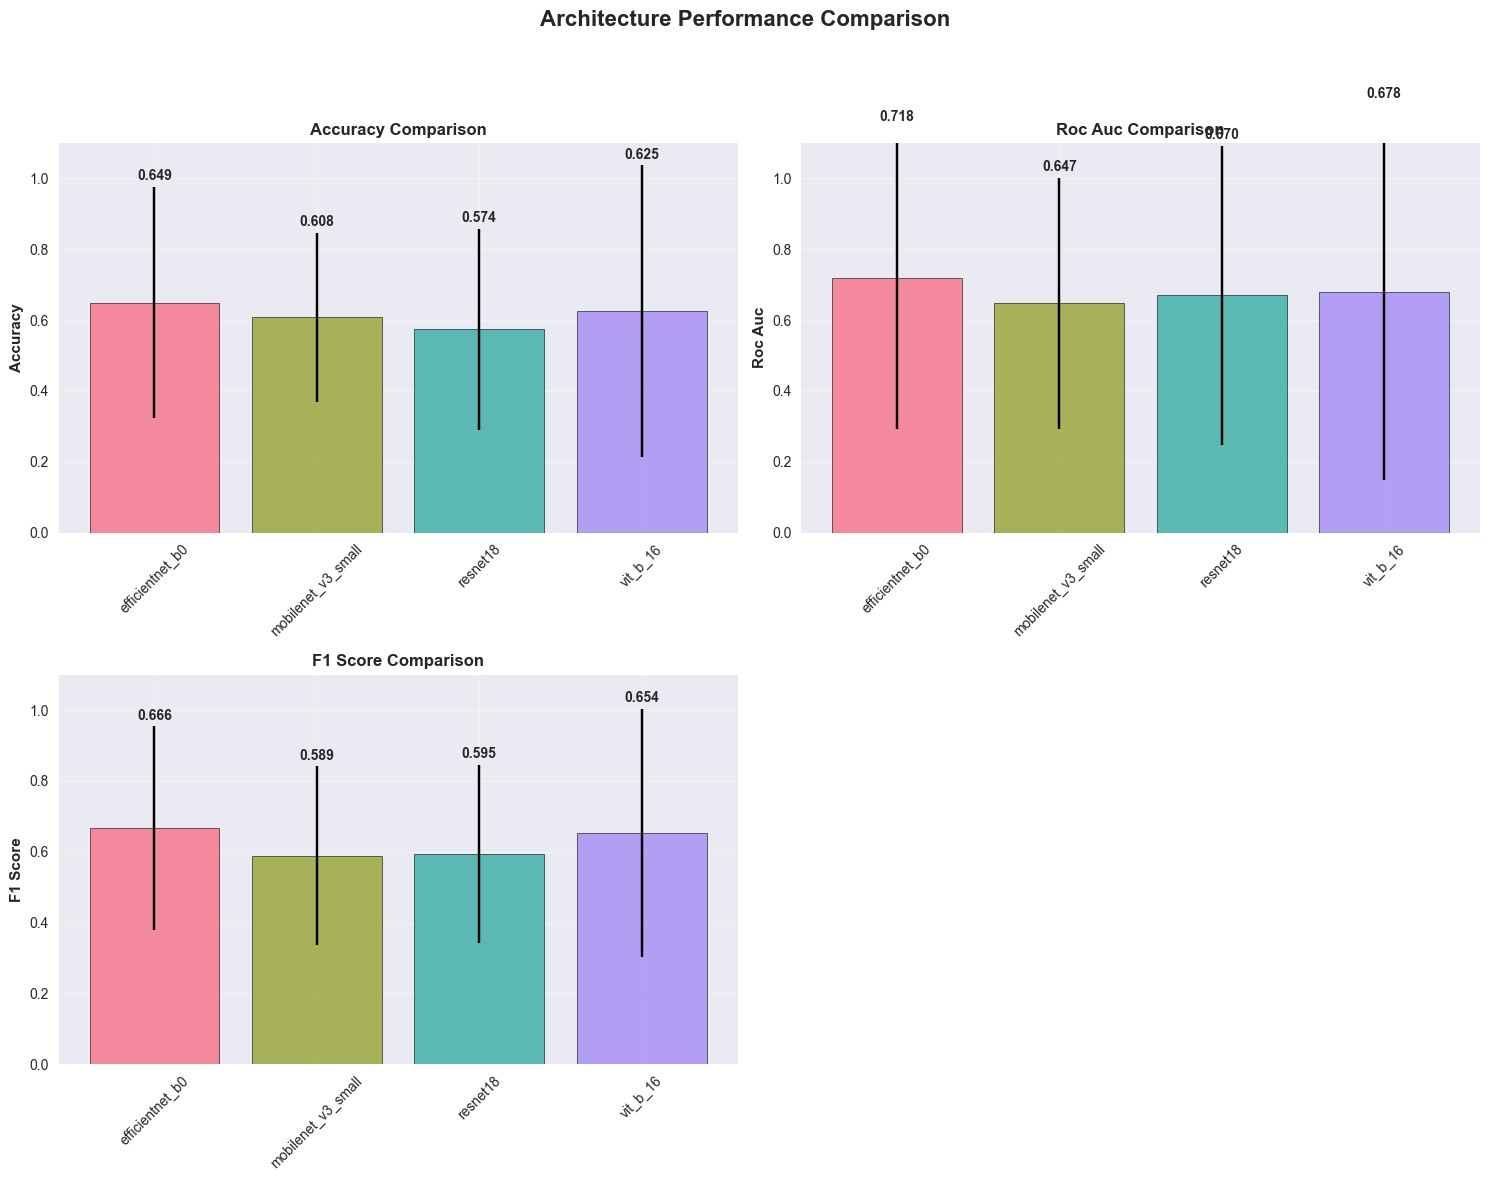

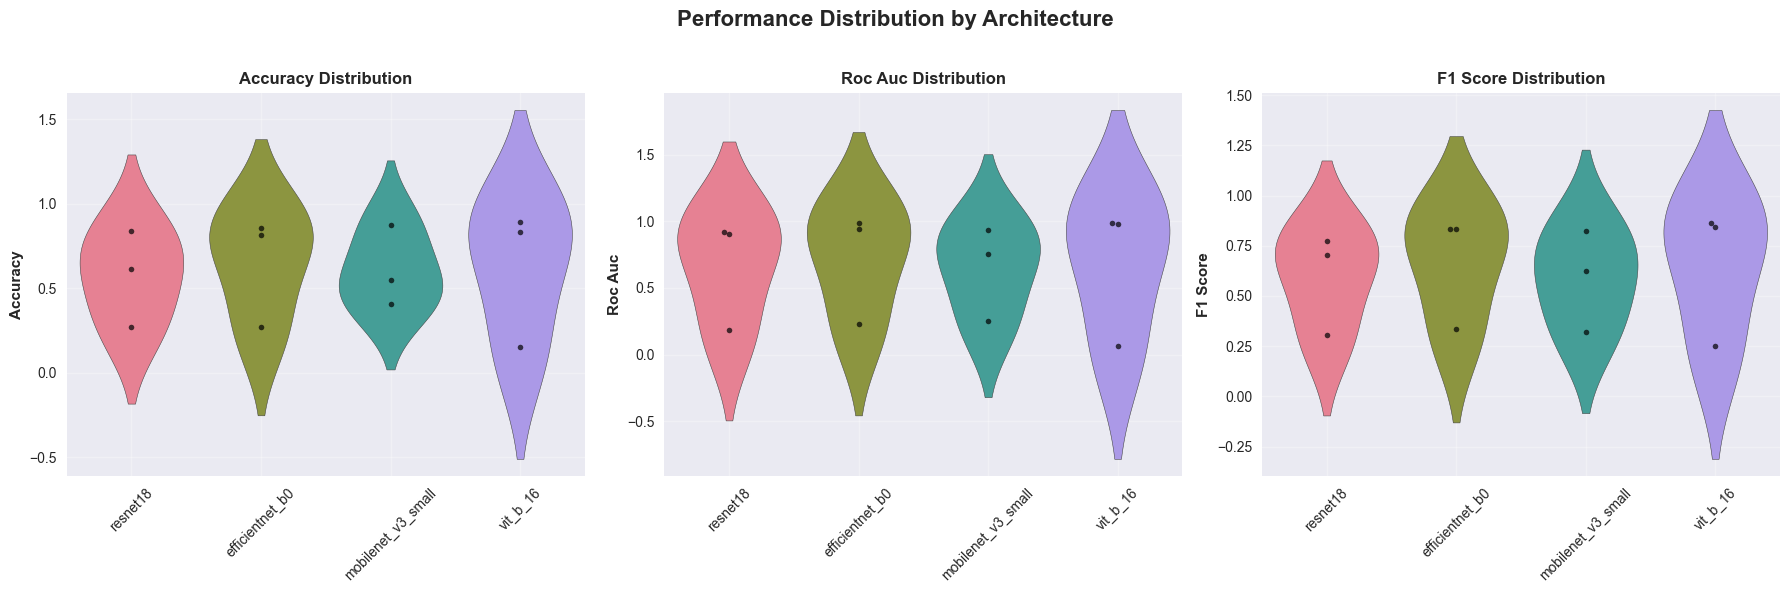

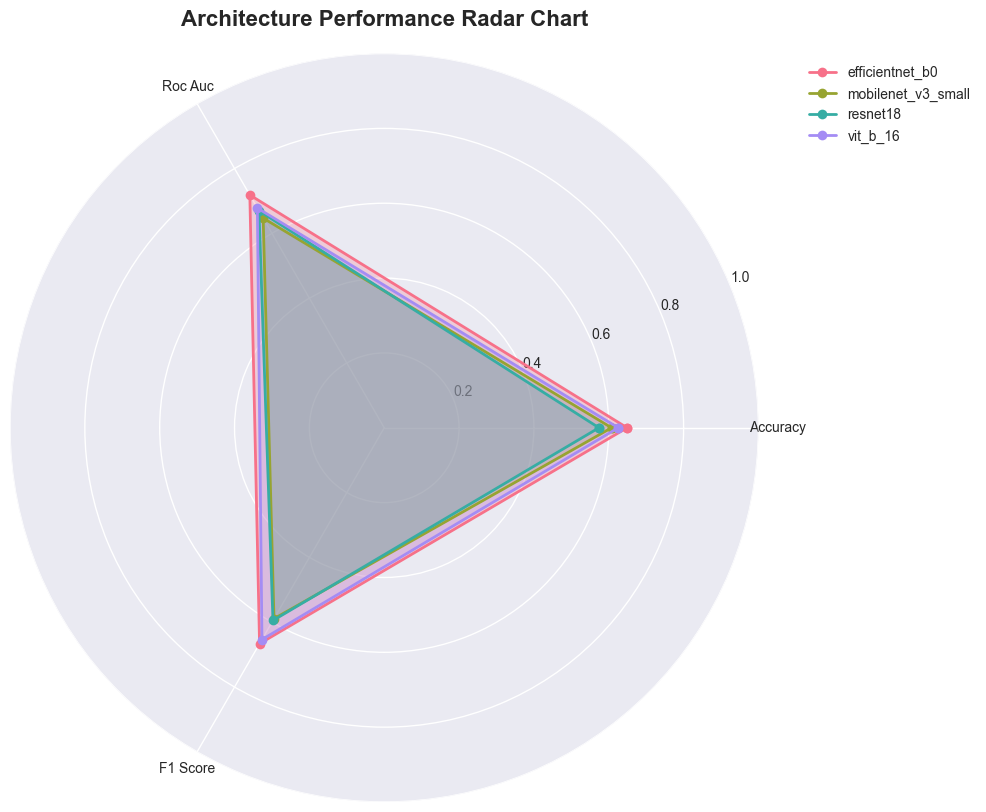

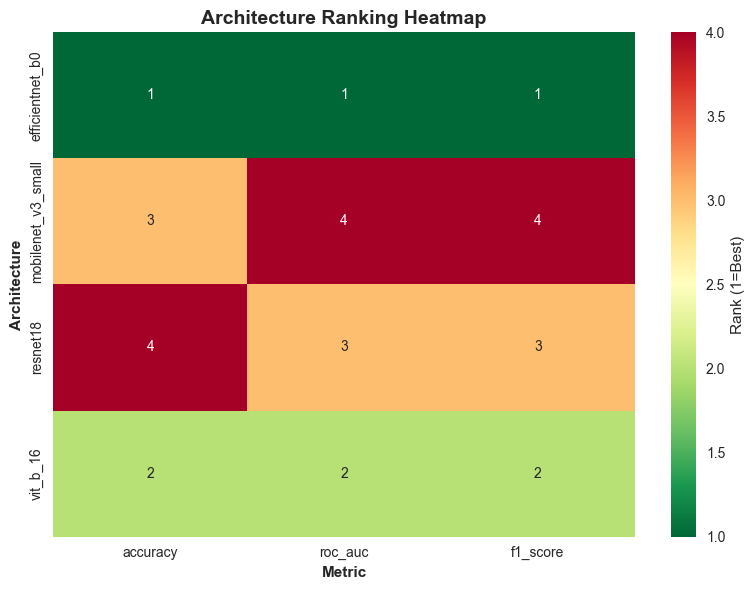


✅ Complete analysis saved to: ../outputs/figures/Switzerland/architecture_comparison/2025-07-26_655529d
📁 Files generated:
   • distribution_plots.png
   • experiment_report.txt
   • formatted_summary.csv
   • metrics_comparison.png
   • radar_chart.png
   • ranking_heatmap.png
   • raw_results.csv
   • summary_statistics.csv


In [36]:
# 6.3 Visualize
# Main execution with pretty output
def run_analysis(all_results, config):
    """Run the complete analysis"""
    results_dir = create_results_directory()

    print(f"\n💾 Saving results to: {results_dir}")

    # Save and process results
    df, summary, formatted_summary, available_metrics = save_detailed_results(all_results, results_dir)

    # Print summary
    print_summary(summary, formatted_summary, available_metrics)

    # Create all visualizations
    create_comparison_plots(df, summary, available_metrics, results_dir)

    # Generate comprehensive report
    generate_report(all_results, config, results_dir, available_metrics)

    print(f"\n✅ Complete analysis saved to: {results_dir}")
    print(f"📁 Files generated:")
    for file_path in sorted(results_dir.glob('*')):
        print(f"   • {file_path.name}")

    return results_dir

# Run the analysis
results_dir = run_analysis(all_results, config)
